<a href="https://colab.research.google.com/github/psakore/IMCFeedArbitration/blob/main/imc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
!pip install scapy
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [88]:
import os
if not os.path.exists('feed_arbitrage.pcap'):
  !wget https://github.com/psakore/IMCFeedArbitration/raw/main/feed_arbitrage.pcap


In [89]:
import sys
import re
from scapy.all import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, widgets, Output
from IPython.display import display, clear_output
import datetime

MAX_TIME = 9999999999999999

In [98]:
# Function to convert microseconds since epoch to HH:MM:SS format
def microseconds_to_hhmmss(microseconds):
    timestamp = datetime.datetime.fromtimestamp(microseconds / 1000000)
    return timestamp.strftime('%H:%M:%S')

In [90]:
def process_packet(packet, data_dict):
    # Extract relevant information from the packet (symbol, seqno, timestamp)
    payload = packet.load.decode("utf-8")
    symbol = re.search(r"Symbol: (\w+)", payload).group(1)
    seqno = int(re.search(r"Seqno: (\d+)", payload).group(1))
    timestamp = int(packet.time * 1000000) # converting to int
    source_ip = packet[IP].src  # Get the source IP address

    # Add the packet information to the data dictionary
    key = "%s_%d" % (symbol, seqno)
    if key not in data_dict:
      data_dict[key] = {}
    data_dict[key][source_ip] = timestamp

In [91]:
def convert_to_df(data_dict):
    df = pd.DataFrame(data_dict).T
    df = df.reindex(sorted(df.columns), axis=1)
    df.index.name = 'Symbol_Seqno'
    df.fillna(MAX_TIME, inplace=True)
    df = df.astype(int)

    df['Fastest_Publisher'] = df.idxmin(axis=1)
    df['Min_Time'] = df.min(axis=1)

    return df

In [95]:
def visualize_metrics(df):
      # Convert Min_Time to microseconds for slider
    min_time_micros = df['Min_Time'].unique()

    min_time_min = df['Min_Time'][0]
    min_time_max = df['Min_Time'][-1]

    # Create an interactive slider with HH:MM:SS format labels
    slider = widgets.SelectionRangeSlider(
        options=[(microseconds_to_hhmmss(x), x) for x in min_time_micros],
        index=(0, len(min_time_micros) - 1),
        description='',  # Empty description
        layout=widgets.Layout(width='50%'),
        continuous_update=False
    )

    # Create a box to arrange the description and range labels
    description_box = widgets.VBox([widgets.Label(value='Time Range to consider:')])

    # Function to update the pie chart and table based on slider values
    def update_pie_chart_table(min_time_range_micros):
        min_time_range = [microseconds_to_hhmmss(x) for x in min_time_range_micros]
        # Filter the DataFrame based on the selected range
        filtered_df = df[(df['Min_Time'] >= min_time_range_micros[0]) & (df['Min_Time'] <= min_time_range_micros[1])]

        top_values = filtered_df['Fastest_Publisher'].value_counts()

        total_sum = top_values.sum()
        cumulative_percentages = [sum(top_values.values[:i+1]) / total_sum * 100 for i in range(len(top_values))]

        # Clear the previous chart and table
        clear_output(wait=True)  # Clear previous output

        # Create a pie chart
        plt.figure(figsize=(7, 7))
        plt.pie(top_values, labels=top_values.index, autopct='%1.2f%%', startangle=140)
        plt.title('Fastest Publishers Distribution')
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        # Define the table data
        table_data = [['Num_Best', 'Publisher', 'Percentage in Pie', 'Cumulative Percentage']]
        for i, (label, value) in enumerate(zip(top_values.index, top_values.values)):
            table_data.append([i + 1, label, f'{value / total_sum * 100 :.2f}%', f'{cumulative_percentages[i]:.2f}%'])

        # Create a table below the pie chart
        table = plt.table(cellText=table_data[1:], loc='bottom', cellLoc='center', colLabels=table_data[0])
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.5, 2)  # Adjust the table size

        # Remove axis for the table
        ax = plt.gca()
        ax.axis('off')

        # Display the updated pie chart and table
        plt.show()
        display(widgets.HBox([description_box, slider]))

    # Define a function to handle slider value changes
    def on_slider_change(change):
        min_time_range_micros = slider.value
        update_pie_chart_table(min_time_range_micros)

    # Attach the slider value change handler
    slider.observe(on_slider_change, names='value')

    # Display the initial pie chart and table
    initial_range_micros = slider.value
    update_pie_chart_table(initial_range_micros)

In [96]:
def main(pcap_file):
    # Initialize a data dictionary to store packet information
    data_dict = {}

    # Iterate through packets, process them, and calculate metrics
    for packet in PcapReader(pcap_file):
        if packet.haslayer(UDP):
            process_packet(packet, data_dict)

    df = convert_to_df(data_dict)
    visualize_metrics(df)


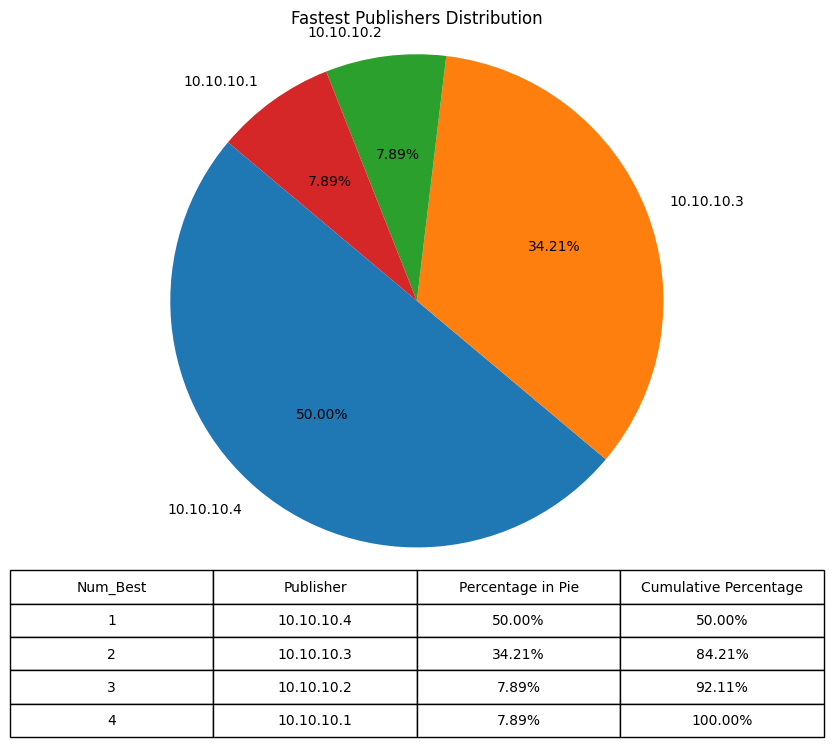

In [97]:
main('feed_arbitrage.pcap')